In [15]:
import sys
from pathlib import Path
curr_path = str(Path().absolute()) # 当前路径
parent_path = str(Path().absolute().parent) # 父路径
sys.path.append(parent_path) # 添加路径到系统路径

import math,random
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output # 清空单元格输出区域

## 网络模型

In [16]:
class MLP(nn.Module):
    def __init__(self, n_states,n_actions,hidden_dim=128):
        """ 初始化q网络，为全连接网络
            n_states: 输入的特征数即环境的状态数
            n_actions: 输出的动作维度
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, n_actions) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## 经验回放

In [17]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # 经验回放的容量
        self.buffer = [] # 缓冲区
        self.position = 0 
    
    def push(self, state, action, reward, next_state, done):
        ''' 缓冲区是一个队列，容量超出时去掉开始存入的转移(transition)
        '''
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity 
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) # 随机采出小批量转移
        state, action, reward, next_state, done =  zip(*batch) # 解压成状态，动作等
        return state, action, reward, next_state, done
    
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

## DQN

In [18]:
class DQN:
    def __init__(self, n_states, n_actions, cfg):

        self.n_actions = n_actions  # 总的动作个数
        self.device = cfg.device  # 设备，cpu或gpu等
        self.gamma = cfg.gamma  # 奖励的折扣因子
        # e-greedy策略相关参数
        self.frame_idx = 0  # 用于epsilon的衰减计数
        self.epsilon = lambda frame_idx: cfg.epsilon_end + \
            (cfg.epsilon_start - cfg.epsilon_end) * \
            math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.batch_size = cfg.batch_size
        self.policy_net = MLP(n_states, n_actions,hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = MLP(n_states, n_actions,hidden_dim=cfg.hidden_dim).to(self.device)
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): # 复制参数到目标网路targe_net
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr) # 优化器
        self.memory = ReplayBuffer(cfg.memory_capacity) # 经验回放

    def choose_action(self, state):
        ''' 选择动作
        '''
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state = torch.tensor([state], device=self.device, dtype=torch.float32)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # 选择Q值最大的动作
        else:
            action = random.randrange(self.n_actions)
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 当memory中不满足一个批量时，不更新策略
            return
        # 从经验回放中(replay memory)中随机采样一个批量的转移(transition)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # 转为张量
        state_batch = torch.tensor(state_batch, device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)  
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)  
        next_state_batch = torch.tensor(next_state_batch, device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch) # 计算当前状态(s_t,a)对应的Q(s_t, a)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach() # 计算下一时刻的状态(s_t_,a)对应的Q值
        # 计算期望的Q值，对于终止状态，此时done_batch[0]=1, 对应的expected_q_value等于reward
        expected_q_values = reward_batch + self.gamma * next_q_values * (1-done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))  # 计算均方根损失
        # 优化更新模型
        self.optimizer.zero_grad()  
        loss.backward()
        for param in self.policy_net.parameters():  # clip防止梯度爆炸
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

### DQN参数

In [19]:
class DQNConfig:
    def __init__(self):
        self.algo = "DQN"  # 算法名称
        self.env = 'CartPole-v0' # 环境名称
        self.train_eps = 200 # 训练的回合数
        self.eval_eps = 30 # 测试的回合数
        self.gamma = 0.95 # 强化学习中的折扣因子
        self.epsilon_start = 0.90 # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 500 # e-greedy策略中epsilon的衰减率
        self.lr = 0.0001  # 学习率
        self.memory_capacity = 100000  # 经验回放的容量
        self.batch_size = 64 # mini-batch SGD中的批量大小
        self.target_update = 4 # 目标网络的更新频率
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 检测GPU
        self.hidden_dim = 256  # 网络隐藏层

## 创建环境

In [20]:
def env_agent_config(cfg,seed=1):
    ''' 创建环境和智能体
    '''
    env = gym.make(cfg.env)  # 创建环境
    env.seed(seed) # 设置随机种子
    n_states = env.observation_space.shape[0] # 状态数
    n_actions = env.action_space.n # 动作数
    agent = DQN(n_states,n_actions,cfg) # 创建智能体
    return env,agent

## 训练

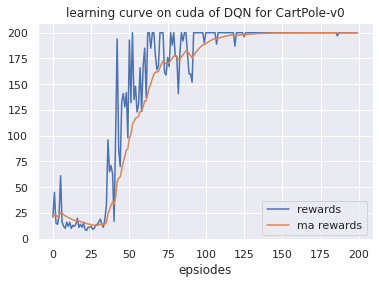

In [21]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print('开始训练!')
    print(f'环境：{cfg.env}, 算法：{cfg.algo}, 设备：{cfg.device}')
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0 # 记录一回合内的奖励
        state = env.reset() # 重置环境，返回初始状态
        while True:
            action = agent.choose_action(state) # 选择动作
            next_state, reward, done, _ = env.step(action) # 更新环境，返回transition
            agent.memory.push(state, action, reward, next_state, done) # 保存transition
            state = next_state # 更新下一个状态
            agent.update() # 更新智能体
            ep_reward += reward # 累加奖励
            if done:
                break
        if (i_ep+1) % cfg.target_update == 0: # 智能体目标网络更新
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        if (i_ep+1)%10 == 0: 
            print('回合：{}/{}, 奖励：{}'.format(i_ep+1, cfg.train_eps, ep_reward))
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
    print('完成训练！')
    return rewards, ma_rewards

def plot_rewards(rewards,ma_rewards,plot_cfg):
    # clear_output(True) # 清空单元格输出区域，因为多次打印，每次需要清楚前面打印的图片
    sns.set() 
    plt.figure() # 创建一个图形实例，方便同时多画几个图
    plt.title("learning curve on {} of {} for {}".format(plot_cfg.device, plot_cfg.algo, plot_cfg.env))
    plt.xlabel('epsiodes')
    plt.plot(rewards,label='rewards')
    plt.plot(ma_rewards,label='ma rewards')
    plt.legend()
    plt.show()

class PlotConfig:
    def __init__(self) -> None:
        self.algo = "DQN"  # 算法名称
        self.env = 'CartPole-v0' # 环境名称
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 检测GPU

cfg = DQNConfig()
plot_cfg = PlotConfig()
env,agent = env_agent_config(cfg,seed=1)
rewards, ma_rewards = train(cfg, env, agent)
plot_rewards(rewards, ma_rewards, plot_cfg) # 画出结果

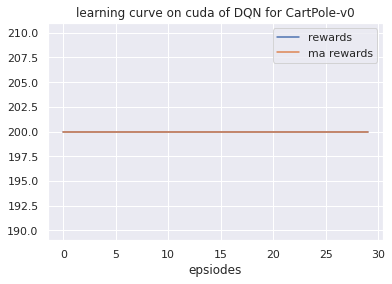

In [23]:
def eval(cfg,env,agent):
    print('开始测试!')
    print(f'环境：{cfg.env}, 算法：{cfg.algo}, 设备：{cfg.device}')
    # 由于测试不需要使用epsilon-greedy策略，所以相应的值设置为0
    cfg.epsilon_start = 0.0 # e-greedy策略中初始epsilon
    cfg.epsilon_end = 0.0 # e-greedy策略中的终止epsilon
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    for i_ep in range(cfg.eval_eps):
        ep_reward = 0 # 记录一回合内的奖励
        state = env.reset() # 重置环境，返回初始状态
        while True:
            action = agent.choose_action(state) # 选择动作
            next_state, reward, done, _ = env.step(action) # 更新环境，返回transition
            state = next_state # 更新下一个状态
            ep_reward += reward # 累加奖励
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep+1)%3 == 0: 
            print(f"回合：{i_ep+1}/{cfg.eval_eps}, 奖励：{ep_reward:.1f}")
    print('完成测试！')
    return rewards,ma_rewards

rewards,ma_rewards = eval(cfg,env,agent)
plot_rewards(rewards,ma_rewards, plot_cfg) # 画出结果
